In [88]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
mne.utils.use_log_level('error')

In [114]:
#subject = subject number
#testtype = VR or Non-VR
def loadRawData(subject, testtype):
    path = "Preprocessed_Data/Subject-"+str(subject)+"_"+testtype+".fif"
    raw = mne.io.read_raw_fif(path, verbose='error')
    return raw

def getFeatures(raw):
    col = ['Mean', 'Median', 'StdDev','Mean/StdDev','Skew','Kurt']
    features = pd.DataFrame(columns = col)
    for i in range(60,160,10): #change to (55,165,10)
        start, stop = raw.time_as_index([i, i+5])
        
        #only looking at CH 4
        picks = mne.pick_types(raw.info, eeg=True, exclude=['CH 1','CH 2','CH 3','CH 5','CH 6','CH 7','CH 8'])
        
        try:    
            d, t = raw[picks[:], start:stop]
            ds = pd.DataFrame(d[0])
            
            #normalize
            #ds = (ds-ds.mean())/(ds.max()-ds.min())
            
            mean = ds.mean()[0]
            median = ds.median()[0]
            std = ds.std()[0]
            mos = mean/std
            skew = ds.skew()[0]
            kurt = ds.kurt()[0]
            features = features.append(pd.Series([mean, median, std, mos, skew, kurt], index=col), ignore_index=True)
        except:
            continue
    return features

In [113]:
columns = ['Subject','Test', 'Channel', 'Mean', 'Median', 'StdDev','Mean/StdDev','Skew','Kurt']

In [91]:
#testtype = VR or Non-VR
df = pd.DataFrame(columns = columns)
for i in range(1,33):
    data = loadRawData(i,"Non-VR")
    f = getFeatures(data)
    l = len(f)
    for j in range(l):
        df = df.append(pd.Series([i, 'Non-VR', 'CH 4', f['Mean'][j], f['Median'][j], f['StdDev'][j], f['Mean/StdDev'][j], f['Skew'][j], f['Kurt'][j]], index=columns), ignore_index=True)

In [92]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(df)

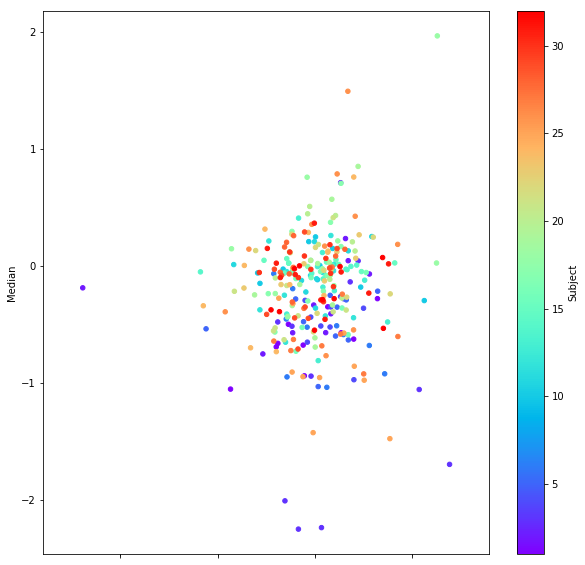

In [93]:
x = "Mean/StdDev"
y = "Median"
c = "Subject"
df.plot.scatter(x=x, y=y, c=c, cmap='rainbow', figsize=[10,10])

In [94]:
import itertools

In [96]:
subs = df['Subject'].unique()    # All subjects
all_subs= list(itertools.combinations(subs, 2)) # All possible combination for all subjects

col = ['Subject', 'Mean', 'Median', 'StdDev','Mean/StdDev','Skew','Kurt', 'Type']
features = ['Mean', 'Median', 'StdDev','Mean/StdDev','Skew','Kurt']
intra_data = pd.DataFrame(columns = col)

#Intra Distance Computation (Same Person)
for sub in subs:
    rows = df.loc[df['Subject'] == sub]
    each_comb = list(itertools.combinations(rows.index, 2))
    for i in range(len(each_comb)):
        comb = each_comb[i]
        r=0
        fdr = [None]*6
        for feature in features:
            f1= df.iloc[comb[0]][feature]
            f2 = df.iloc[comb[1]][feature]
            Intra_dis = np.absolute(f1-f2) # absolute difference formula
            fdr[r] = Intra_dis
            r+=1
        intra_data = intra_data.append(pd.Series([sub,fdr[0],fdr[1],fdr[2],fdr[3],fdr[4],fdr[5],0], index=col), ignore_index=True)

In [107]:
col = ['Subjects', 'Mean', 'Median', 'StdDev','Mean/StdDev','Skew','Kurt', 'Type']
inter_data = pd.DataFrame(columns = col)

# Inter Distance Computation (Different Person) 
all_rows=len(df)
for sub_pair in all_subs: # Pairs of subjets
    sp1 = df.loc[df['Subject'] == sub_pair[0]].index
    sp2 = df.loc[df['Subject'] == sub_pair[1]].index
    for i in range(len(sp1)):
        for j in range(len(sp2)):
            r=0
            fdr = [None]*6
            for feature in features:
                f1 = df.iloc[sp1[i]][feature] 
                f2 = df.iloc[sp2[j]][feature] 
                Inter_dis = np.absolute(f1-f2) # absolute difference formula
                fdr[r] = Inter_dis
                r+=1
            inter_data = inter_data.append(pd.Series([sub_pair, fdr[0],fdr[1],fdr[2],fdr[3],fdr[4],fdr[5], 1], index=col), ignore_index=True)

In [139]:
print("Intra length: "+str(len(intra_data)))
print("Inter length: "+str(len(inter_data)))

Intra length: 1305
Inter length: 40600


In [138]:
intra_data

,Subject,Mean,Median,StdDev,Mean/StdDev,Skew,Kurt,Type
0,1.0,0.035888,0.054047,1.755340,0.002577,0.746091,4.101319,0.0
1,1.0,0.100000,0.313789,1.847490,0.010139,0.599810,2.605879,0.0
2,1.0,0.101331,0.051314,2.143800,0.010382,1.040307,5.755936,0.0
3,1.0,0.058659,0.345634,0.666057,0.004883,0.654004,1.482708,0.0
4,1.0,0.158719,0.066570,0.581931,0.015921,0.304570,1.728633,0.0
5,1.0,0.245566,0.427394,0.815417,0.025313,0.254396,2.124558,0.0
6,1.0,0.145528,0.036531,1.887318,0.015587,0.586197,3.061640,0.0
7,1.0,0.128565,0.126711,1.678438,0.013425,0.627635,3.474204,0.0
8,1.0,0.059461,0.275809,1.838336,0.005323,0.126345,3.109972,0.0
9,1.0,0.064112,0.367835,0.092150,0.007562,0.146281,1.495440,0.0


In [111]:
inter_data

,Subjects,Mean,Median,StdDev,Mean/StdDev,Skew,Kurt,Type
0,"(1, 2)",0.658958,0.438070,1.835019,0.055689,0.890097,0.066864,1
1,"(1, 2)",0.033642,1.336670,11.583288,0.002681,1.720428,0.388648,1
2,"(1, 2)",0.013699,0.556335,1.742016,0.003236,0.881777,3.459164,1
3,"(1, 2)",0.301118,0.126867,10.233931,0.018668,1.226744,2.976341,1
4,"(1, 2)",0.117955,0.054146,2.338617,0.012541,0.762547,3.009630,1
5,"(1, 2)",0.108413,0.291067,93.616625,0.008218,1.823563,10.325933,1
6,"(1, 2)",0.053565,0.216277,1.665506,0.004690,0.613095,2.623691,1
7,"(1, 2)",0.061611,0.055139,1.167063,0.005754,0.710607,3.258427,1
8,"(1, 2)",0.033234,0.859201,2.543978,0.001683,1.041511,3.212007,1
9,"(1, 2)",0.029232,0.670032,2.582452,0.001130,1.006432,3.023602,1


In [195]:
subF1 = pd.DataFrame(columns = col)
subF2 = pd.DataFrame(columns = col)
subF3 = pd.DataFrame(columns = col)
intra = intra_data.copy()
inter = inter_data.copy()

In [196]:
#import random
#for i in range(0,len(intra),9):
#    rands = random.sample(range(i, i+8), 3)
#    for rand in rands:
#        subF1 = subF1.append(intra.iloc[rand])
    

In [197]:
for i in range(len(intra_data)):
    if(i%3==0):
        subF1 = subF1.append(intra_data.iloc[i],ignore_index=True)
    if(i%3==1):
        subF2 = subF2.append(intra_data.iloc[i],ignore_index=True)
    if(i%3==2):
        subF3 = subF3.append(intra_data.iloc[i],ignore_index=True)

        
for i in range(len(inter_data)):
    if(i%3==0):
        subF1 = subF1.append(inter_data.iloc[i],ignore_index=True)
    if(i%3==1):
        subF2 = subF2.append(inter_data.iloc[i],ignore_index=True)
    if(i%3==2):
        subF3 = subF3.append(inter_data.iloc[i],ignore_index=True)

In [204]:
import random
svm1 = pd.DataFrame(columns = col)
rands = random.sample(range(0, 435), 400)
for rand in rands:
    svm1 = svm1.append(subF1.iloc[rand],ignore_index=True)
    
rands = random.sample(range(435, 13969), 600)
for rand in rands:
    svm1 = svm1.append(subF1.iloc[rand],ignore_index=True)

In [205]:
len(svm1)

1000

In [206]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [207]:
X = svm1.drop(['Subjects','Subject','Type'], axis=1)
y = svm1["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [208]:
model = SVC(C=1.0, kernel = 'rbf', degree=3, gamma='auto')

In [209]:
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [210]:
prediction = model.predict(X_test)

In [211]:
from sklearn.metrics import confusion_matrix, classification_report

In [212]:
print(confusion_matrix(y_test, prediction))

[[ 79  42]
 [ 34 145]]


In [213]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

         0.0       0.70      0.65      0.68       121
         1.0       0.78      0.81      0.79       179

   micro avg       0.75      0.75      0.75       300
   macro avg       0.74      0.73      0.73       300
weighted avg       0.74      0.75      0.75       300

